In [1]:
# Clears out any variables, just to be safe.
%reset -f

import tkinter as tk
from tkinter import * # Keep this for constants like HORIZONTAL, W, etc.
from tkinter import ttk
from tkinter import filedialog
from tkinter.ttk import Progressbar
import pandas as pd
import matplotlib.pyplot as plt
from  matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
import plotly.graph_objects as go
import numpy as np
import math
import os
import re
import sys
import json
import ast
from time import perf_counter
from time import perf_counter_ns
import seaborn as sns
from scipy.optimize import curve_fit

In [2]:
# --- Global variables for file paths ---
data_filename = ""
temp_profile_file = ""
layout_file = ""
mating_table_file = ""
fur_file = ""
hps_file = ""
runData = [] # This will store all final data for plotting/export
runBool = False
imageViewer = None # For the main Moles/P/T plot
temp_viewer_window = None
baselineEdited = False
z_temp_cutoff_var = None
z_offset_var = None
p_calc_start_time_var = None
interpolate_temps_var = None

In [3]:
# --- Fit & Uncertainty Widgets ---
fit_start_time_var = None
fit_end_time_var = None
fit_results_label = None
calculateFitButton = None
sigma_p_var = None # <-- NEW
sigma_v_var = None # <-- NEW
sigma_t_var = None # <-- NEW
# ---

exportTempButton = None # Initialize button variables
tempViewButton = None
exportPlotButton = None
importTempButton = None

In [4]:
# --- browseFiles function ---
def browseFiles():
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file, interpolate_temps_var

    data_filename = filedialog.askopenfilename(
        initialdir=os.path.expanduser('~\\Lehigh University Dropbox'),
        title="1. Select Data CSV File",
        filetypes=(("CSV files", "*.csv*"), ("all files", "*.*"))
    )
    if data_filename: fileLabel.configure(text=f"Data: {os.path.basename(data_filename)}")
    else: fileLabel.configure(text="Data: (Not Selected)")
    start_dir = os.path.dirname(data_filename) if data_filename else os.path.expanduser('~')

    if not interpolate_temps_var.get(): # Only ask if checkbox is NOT checked
        temp_profile_file = filedialog.askopenfilename(
            initialdir=start_dir,
            title="2. Select Temperature Profile CSV", filetypes=(("CSV files", "*.csv*"),)
        )
        if temp_profile_file: tempLabel.configure(text=f"Temp Profile: {os.path.basename(temp_profile_file)}", state='normal')
        else: tempLabel.configure(text="Temp Profile: (Not Selected)", state='normal')
    else:
        temp_profile_file = "" # Clear if checkbox is checked
        tempLabel.configure(text="Temp Profile: (Using Interpolation)", state='disabled') # Indicate interpolation

    layout_file = filedialog.askopenfilename(
        initialdir=start_dir, title="3. Select Layout File (Excel)", filetypes=(("Excel files", "*.xlsx*"),)
    )
    if layout_file: layoutLabel.configure(text=f"Layout: {os.path.basename(layout_file)}")
    else: layoutLabel.configure(text="Layout: (Not Selected)")

    mating_table_file = filedialog.askopenfilename(
        initialdir=start_dir, title="4. Select Mating Table (Excel)", filetypes=(("Excel files", "*.xlsx*"),)
    )
    if mating_table_file: matingLabel.configure(text=f"Mating Table: {os.path.basename(mating_table_file)}")
    else: matingLabel.configure(text="Mating Table: (Not Selected)")

    fur_file = filedialog.askopenfilename(
        initialdir=start_dir, title="5. Select MLD - FUR (Excel)", filetypes=(("Excel files", "*.xlsx*"),)
    )
    if fur_file: furLabel.configure(text=f"MLD-FUR: {os.path.basename(fur_file)}")
    else: furLabel.configure(text="MLD-FUR: (Not Selected)")

    hps_file = filedialog.askopenfilename(
        initialdir=start_dir, title="6. Select MLD - HPS (Excel)", filetypes=(("Excel files", "*.xlsx*"),)
    )
    if hps_file: hpsLabel.configure(text=f"MLD-HPS: {os.path.basename(hps_file)}")
    else: hpsLabel.configure(text="MLD-HPS: (Not Selected)")

    window.update_idletasks()

In [5]:
# --- Toggle Temp File Label State ---
def toggle_temp_file_selection():
    global interpolate_temps_var, tempLabel, temp_profile_file
    if interpolate_temps_var.get():
        tempLabel.configure(text="Temp Profile: (Using Interpolation)", state='disabled')
        temp_profile_file = ""
    else:
        tempLabel.configure(text="Temp Profile: (Select Below)", state='normal')

In [6]:
# --- getData function ---
def getData(runDF_raw, EXP_ID):
    global graphLabel
    print("running getData")
    config_path = os.path.expanduser(r"~\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\") + EXP_ID + '.csv'
    print(config_path)
    try:
        TC_df = pd.read_csv(config_path, usecols=['Device Type', 'NI LV Channel','Shorthand Tag', 'IO Type'])
    except FileNotFoundError: graphLabel.configure(text=f"Error: TC config file not found for {EXP_ID}.csv"); return None, None, None
    except ValueError as e: graphLabel.configure(text=f"Error: Check columns in {EXP_ID}.csv"); return None, None, None
    original_rows = len(TC_df); TC_df.drop_duplicates(subset=['NI LV Channel'], keep='first', inplace=True)
    if len(TC_df) < original_rows: print(f"Removed {original_rows - len(TC_df)} duplicate NI LV Channels.")
    positions = []
    for name, type in zip(TC_df['Shorthand Tag'], TC_df['Device Type']):
        if type == 'TC':
            numbers_found = re.findall(r"\d+", str(name))
            if len(numbers_found) >= 2:
                try: positions.append(int(numbers_found[1]))
                except (ValueError, IndexError): print(f"Warn: Bad TC tag num: '{name}'."); positions.append(np.nan)
            else: print(f"Warn: <2 nums in TC tag: '{name}'."); positions.append(np.nan)
        else: positions.append(np.nan)
    TC_df['X Position'] = positions; TC_df = TC_df.dropna(subset=['X Position'])
    try: TC_df['X Position'] = TC_df['X Position'].astype(int)
    except ValueError: print("Warn: X Pos not int.")
    TC_df = TC_df.sort_values(by='X Position'); TC_positions=TC_df['X Position']
    print("TC_positions (valid & sorted):", TC_positions.tolist()); print("TC_df (valid TCs, unique channels):"); print(TC_df[['NI LV Channel', 'Shorthand Tag', 'X Position', 'IO Type']])
    RelevantColumns = TC_df['NI LV Channel'].to_list()
    if not RelevantColumns: graphLabel.configure(text=f"Error: No valid TCs in config."); return None, None, None
    unique_required_cols = list(dict.fromkeys(RelevantColumns + ["CV1-TC-Ambient"]))
    missing_cols = [col for col in unique_required_cols if col not in runDF_raw.columns]
    if missing_cols: graphLabel.configure(text=f"Error: Data missing cols: {missing_cols}"); return None, None, None
    try:
        runDF_selected = runDF_raw[unique_required_cols].iloc[8:]
        print("Converting temperature columns to numeric...")
        runDF_selected = runDF_selected.apply(pd.to_numeric, errors='coerce')
        runDF_filtered = runDF_selected.dropna()
        if runDF_filtered.empty: graphLabel.configure(text="Error: No valid data rows found after filtering & coercion."); return None, None, None
        print(f"Data rows remaining after filtering: {len(runDF_filtered)}")
        return runDF_filtered, TC_df, TC_positions
    except Exception as e: graphLabel.configure(text=f"Error filtering data: {e}"); return None, None, None


In [7]:
# --- getTempProfile function ---
def getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list):
    profileSegments = [];
    try: temps_float = [float(t) for t in temps]
    except ValueError: print("Error: Non-numeric temp reading passed to getTempProfile."); return []
    for i in range(len(z_list_str)):
        temp_df = temp_df_list[i]; col_name = z_list_str[i]
        if col_name not in temp_df.columns: print(f"Error: Col '{col_name}' missing."); return []
        search_column = temp_df[col_name]
        try: idx = search_column.searchsorted(temps_float[i]); safe_idx = min(idx, len(temp_df) - 1); tempList = temp_df.iloc[safe_idx]
        except Exception as e: print(f"Error in search/iloc seg {i}: {e}"); return []
        profileSegments.append(tempList)
    if not profileSegments: return []
    try: tempProfile = pd.concat(profileSegments); tempProfile = tempProfile[~tempProfile.index.duplicated(keep='first')].tolist()
    except Exception as e: print(f"Error concat temp: {e}"); return []
    try: tempProfile = [float(t) for t in tempProfile]
    except ValueError: print("Error: Non-numeric value in calculated temp profile."); return []
    return tempProfile

In [8]:
# --- interpolateTempProfile function ---
def interpolateTempProfile(current_temps, tc_positions_series):
    """Linearly interpolates temperatures based on a 3-point profile."""
    try: temps_float = [float(t) for t in current_temps]
    except ValueError: print("Error: Non-numeric temp reading passed to interpolate."); return []
    if len(temps_float) != len(tc_positions_series): print("Error: Temps/Positions mismatch in interpolation."); return []
    try: x_known_values = tc_positions_series.astype(float).values
    except ValueError: print("Error: TC positions not convertible to float."); return []
    sorted_indices = np.argsort(x_known_values); x_known = x_known_values[sorted_indices]; y_known = np.array(temps_float)[sorted_indices]
    min_pos = x_known[0]; min_temp = y_known[0]; max_pos = x_known[-1]; max_temp = y_known[-1]
    peak_temp = np.max(y_known); peak_pos = x_known[np.argmax(y_known)]
    interp_data = {min_pos: min_temp, peak_pos: peak_temp, max_pos: max_temp}
    x_final_pts = sorted(interp_data.keys()); y_final_pts = [interp_data[x] for x in x_final_pts]
    if len(x_final_pts) < 2: print(f"Warn: Only one unique TC pos ({x_final_pts})."); return [y_final_pts[0]] * (int(max_pos - min_pos) + 1 if max_pos > min_pos else 10)
    x_target = np.arange(int(min_pos), int(max_pos) + 1)
    interpolated_temps = np.interp(x_target, x_final_pts, y_final_pts)
    return interpolated_temps.tolist()

In [9]:
# --- getPartVolProfile function ---
def getPartVolProfile(data):
    APdata = data["Axial Position (mm)"]; CSdata=data["Cross-Sectional Area (mm^2)"]; TMdata=data["Transition Model"]
    areaProfile = []
    for i in range(len(APdata)-1):
        x = np.arange(APdata[i], APdata[i+1], 0.1)
        if TMdata[i] != 'Constant':
            try: sectionAreaProfile = eval(TMdata[i])
            except Exception as e: print(f"Error eval TM '{TMdata[i]}': {e}"); sectionAreaProfile = np.full((1,len(x)), CSdata[i])[0]
        else: sectionAreaProfile = np.full((1,len(x)), CSdata[i])[0]
        areaProfile.append(sectionAreaProfile)
    areaProfile.append(np.array([CSdata[-1]])); areaProfile = np.concatenate(areaProfile)
    volumeProfile = [0.1*slice for slice in areaProfile]
    return volumeProfile

In [10]:
# --- getSystemVolumeProfile function ---
def getSystemVolumeProfile(partList, mating_table_path, fur_path, hps_path):
    global graphLabel; isReversed = False; previousIsReversed = False; cumulativeOffset = 0
    try:
        planeTable = pd.read_excel(mating_table_path)
        furnitureDict = pd.read_excel(fur_path, sheet_name=['CRU', 'LID', 'PLU', 'VRE', 'TUB'])
        HPSDict = pd.read_excel(hps_path, sheet_name=['AC', 'GKT', 'NZ'])
    except Exception as e: graphLabel.configure(text=f"Error reading geometry: {e}"); return None

    CRU, LID, PLU, VRE, TUB = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(furnitureDict.values(), furnitureDict.keys())]
    AC, GKT, NZ = [sheet[["UID", "Profile"]].dropna() for sheet, key in zip(HPSDict.values(), HPSDict.keys())]
    partsDF = pd.concat([CRU,LID,PLU,VRE,AC,GKT,NZ,TUB], ignore_index=True)

    def safe_parse_profile(profile):
        if isinstance(profile, str): profile = profile.strip()
        if isinstance(profile, str) and (profile.endswith("'") or profile.endswith('"')): profile = profile[:-1]
        if isinstance(profile, str) and (profile.startswith("'") or profile.startswith('"')): profile = profile[1:]
        if isinstance(profile, str):
            try: return ast.literal_eval(profile)
            except Exception as e: raise ValueError(f"Invalid profile string: {profile}") from e
        return profile

    partList = partList.dropna(); relevantParts = pd.DataFrame(columns=['UID', 'Profile'])
    for index, row in partList.iterrows():
        partProfile = partsDF.loc[partsDF['UID'] == row['UID']]
        if len(partProfile)!=0: relevantParts=pd.concat([relevantParts, partProfile], ignore_index=True)
    if relevantParts.empty: graphLabel.configure(text="Error: No relevant parts found."); return None

    part_series_dict = {}; mate_positions = []; partVolumes = {}; placement_summaries = []
    if relevantParts.empty: graphLabel.configure(text="Error: No parts to process."); return None
    uid0 = str(relevantParts["UID"].iloc[0])
    mate_positions.append({"Part":f"Part_0_{uid0}", "Previous Mate Position": None, "Next Mate Position": None})

    for i in range(len(relevantParts) - 1):
        try:
            previousPart = safe_parse_profile(relevantParts["Profile"].iloc[i]); nextPart = safe_parse_profile(relevantParts["Profile"].iloc[i + 1])
            if not isinstance(previousPart, dict) or not isinstance(nextPart, dict): raise ValueError(f"Profile not dict at index {i}/{i+1}")
            previousPartPlanes = previousPart.get('Contact Plane'); nextPartPlanes = nextPart.get('Contact Plane')
            if previousPartPlanes is None or nextPartPlanes is None: raise KeyError(f"'Contact Plane' missing at {i}/{i+1}")
            nextPartPlanesReversed = [''.join([c if c!='^' and c!='v' else '^' if c=='v' else 'v' for c in p]) for p in reversed(nextPartPlanes)]
            previousPartAxialPositions = previousPart.get('Axial Position (mm)'); nextPartAxialPositions = nextPart.get('Axial Position (mm)')
            if previousPartAxialPositions is None or nextPartAxialPositions is None: raise KeyError(f"'Axial Position' missing at {i}/{i+1}")
            previousPartVolumeProfile = getPartVolProfile(previousPart)

            if i==0:
                colName0 = f"Part_0_{uid0}"; first_part_slice_idx = list(range(len(previousPartVolumeProfile)))
                if first_part_slice_idx: part_series_dict[colName0] = pd.Series(previousPartVolumeProfile, index=first_part_slice_idx); cumulativeOffset = (len(previousPartVolumeProfile)-1)/10.0
                else: cumulativeOffset = 0.0

            if isReversed:
                previousPartPlanes = [''.join([c if c!='^' and c!='v' else '^' if c=='v' else 'v' for c in p]) for p in reversed(previousPartPlanes)]
                previousPartAxialPositions.reverse(); previousPartVolumeProfile.reverse(); previousIsReversed = True

            mateList = []
            for plane in previousPartPlanes:
                 matches = planeTable.loc[planeTable['Plane'] == plane]
                 if not matches.empty and 'Valid Mates' in matches.columns: mates_str = matches['Valid Mates'].iloc[-1]; mateList.append(mates_str.split(', ') if pd.notna(mates_str) else [])
                 else: mateList.append([])

            normalMates = []; reversedMates = []
            for j in reversed(range(len(mateList))):
                is_rest = lambda s: "REST" in str(s).upper(); nn = [c for c in normalMates if not is_rest(c[0])]; rr = [c for c in reversedMates if not is_rest(c[0])]
                if nn or rr: normalMates, reversedMates = nn, rr
                for k in range(len(nextPartPlanes)):
                    if nextPartPlanes[k] in mateList[j]: normalMates.append([previousPartPlanes[j], j, nextPartPlanes[k], k])
                for k in range(len(nextPartPlanesReversed)):
                    if nextPartPlanesReversed[k] in mateList[j]: reversedMates.append([previousPartPlanes[j], j, nextPartPlanesReversed[k], k])

            if len(normalMates) > 0 and len(reversedMates) == 0: validMateList = normalMates[0]; isReversed = False
            elif len(reversedMates) > 0 and len(normalMates) == 0: validMateList = reversedMates[0]; isReversed=True; print(f"Reversed: {relevantParts['UID'].iloc[i+1]}")
            elif len(normalMates)>0 and len(reversedMates)>0:
                jn, jr = normalMates[0][1], reversedMates[0][1]
                if any(x in relevantParts["UID"].iloc[i+1] for x in ["AC","GKT","GPA"]): validMateList=normalMates[0]
                elif jr == jn: validMateList = normalMates[0]; isReversed = False
                elif jr != jn:
                    if jr > jn: validMateList = reversedMates[0]; isReversed = True; print(f"Reversed (top plane): {relevantParts['UID'].iloc[i+1]}")
                    else: validMateList = normalMates[0]; isReversed = False
                elif any([any(x in str(p) for x in ['GASK','ORING']) for p in normalMates]): validMateList=normalMates[0]; isReversed=False
                elif any([any(x in str(p) for x in ['GASK','ORING']) for p in reversedMates]): validMateList=reversedMates[0]; isReversed=True; print(f"Reversed (gask/oring): {relevantParts['UID'].iloc[i+1]}")
                else: validMateList = normalMates[0]; isReversed = False
            else: raise ValueError(f"No valid mates for {relevantParts['UID'].iloc[i+1]} to {relevantParts['UID'].iloc[i]}.")

            nextPartVolumeProfile = getPartVolProfile(nextPart); partVolume_mm3 = np.sum(nextPartVolumeProfile); partVolumes[relevantParts['UID'].iloc[i+1]] = partVolume_mm3
            if isReversed: nextPartAxialPositions.reverse(); x_max = max(nextPartAxialPositions); nextPartAxialPositions = [x_max-x for x in nextPartAxialPositions]; nextPartVolumeProfile.reverse()
            j = validMateList[1]; k = validMateList[3]; prev_part_end = max(previousPartAxialPositions); next_start = min(nextPartAxialPositions)
            if previousIsReversed: d_prev = previousPartAxialPositions[j]
            else: d_prev = prev_part_end - previousPartAxialPositions[j]
            d_next = nextPartAxialPositions[k]
            if previousPartAxialPositions[j] == prev_part_end and nextPartAxialPositions[k] == next_start: part_Offset = 0.0
            else: part_Offset = d_prev + d_next
            part_length = (len(nextPartVolumeProfile)-1)/10.0; start_pos = cumulativeOffset - part_Offset; next_mate = round(start_pos + nextPartAxialPositions[k],3)
            next_part_uid = relevantParts['UID'].iloc[i+1]; colName = f"Part_{i+1}_{next_part_uid}"
            slice_idx = [int(round(10 * start_pos)) + num for num in range(len(nextPartVolumeProfile))]
            if slice_idx: part_series_dict[colName] = pd.Series(nextPartVolumeProfile, index=slice_idx)
            uid_prev = relevantParts['UID'].iloc[i]; summary = [(f"{uid_prev} mated to {next_part_uid} at {next_mate} mm"),(f"{validMateList[0]} → {validMateList[2]}")]; placement_summaries.append(summary)
            if i == 0: mate_positions[0]["Previous Mate Position"] = 0.00
            mate_positions.append({"Part": f"Part_{i+1}_{next_part_uid}","Previous Mate Position": start_pos,"Next Mate Position": next_mate})
            mate_positionsDF = pd.DataFrame(mate_positions).reset_index(drop=True)
            cumulativeOffset = start_pos + part_length
        except Exception as e: error_msg = f"Error part {i+1} ({relevantParts['UID'].iloc[i+1]}): {e}"; print(error_msg); graphLabel.configure(text=error_msg); return None

    if not part_series_dict: graphLabel.configure(text="Error: No part data."); return None
    try: volumeDF = pd.DataFrame(part_series_dict)
    except Exception as e: graphLabel.configure(text=f"Error creating vol DF: {e}"); return None
    volumeDF.sort_index(inplace=True); volumeDF.fillna(0, inplace=True); volumeDF["Axial Position"] = volumeDF.index * 0.1; volumeDF["Total Volume"] = volumeDF.iloc[:, :-1].sum(axis=1)

    print("\nPLACEMENT SUMMARY:"); print("-" * 60); [print(f"{p}\n{m}\n{'-'*60}") for p, m in placement_summaries]
    print("\nMate Positions"); print(mate_positionsDF); print("\nVolume per part (mL):")
    [print(f"{col}: {volumeDF[col].sum()/1000:.3f} mL") for col in part_series_dict.keys() if col in volumeDF]
    print('\npartList:', partList); volumeDF.to_csv('volumeDF_AC-TG.csv', index=True)

    plot_cols = list(part_series_dict.keys())
    if not plot_cols: print("Warning: No 'Part' columns found for plotting.")
    for col in plot_cols:
        try: # Plotting individual parts
             y_data = volumeDF[col]; x_data = volumeDF["Axial Position"]
             if not (x_data.empty or y_data.empty or (y_data == 0).all()):
                 fig=go.Figure(); fig.add_trace(go.Scatter(x=x_data, y=y_data)); fig.update_layout(title=f"Vol: {col}"); fig.show() # Optional
        except Exception as e: # Catch plotting errors for individual parts
            print(f"Err plot {col}: {e}")

    try: # Plotting total volume
         x_values = volumeDF["Axial Position"]; y_data = volumeDF["Total Volume"]
         if not (x_values.empty or y_data.empty or (y_data==0).all()):
             fig=go.Figure(); fig.add_trace(go.Scatter(x=x_values, y=y_data, name='Total')); [fig.add_vline(x=p.get("Next Mate Position"),line_dash="dash") for p in mate_positions if p.get("Next Mate Position") is not None]; fig.update_layout(title='Total Volume'); fig.show() # Optional
    except Exception as e: print(f"Err plot total: {e}")

    return volumeDF

In [11]:
# --- processData function ---
def processData():
    global runData, baselineEdited, graphLabel, fileProgress, graphProgress
    global data_filename, temp_profile_file, layout_file, mating_table_file, fur_file, hps_file
    global z_temp_cutoff_var, z_offset_var, p_calc_start_time_var, interpolate_temps_var
    global exportTempButton, tempViewButton, exportPlotButton, calculateFitButton, fit_results_label
    global sigma_p_var, sigma_v_var, sigma_t_var # <-- NEW

    if exportPlotButton: exportPlotButton.configure(state='disabled')
    if exportTempButton: exportTempButton.configure(state='disabled')
    if tempViewButton: tempViewButton.configure(state='disabled')
    if calculateFitButton: calculateFitButton.configure(state='disabled')
    if fit_results_label: fit_results_label.configure(text="")

    if not data_filename: graphLabel.configure(text="Error: Select Data File."); return
    use_interpolation = interpolate_temps_var.get()
    if not use_interpolation and not temp_profile_file: graphLabel.configure(text="Error: Select Temp Profile or check Interpolate."); return
    if not layout_file: graphLabel.configure(text="Error: Select Layout File."); return
    if not mating_table_file: graphLabel.configure(text="Error: Select Mating Table."); return
    if not fur_file: graphLabel.configure(text="Error: Select MLD-FUR File."); return
    if not hps_file: graphLabel.configure(text="Error: Select MLD-HPS File."); return

    z_temp_cutoff_mm = None
    try: 
        z_cutoff_input = z_temp_cutoff_var.get();
        if z_cutoff_input: z_temp_cutoff_mm = int(float(z_cutoff_input)); print(f"Using Z-Temp Cutoff: {z_temp_cutoff_mm} mm")
    except ValueError: 
        graphLabel.configure(text="Error: Invalid Z-Temp Cutoff."); return

    z_offset_mm = 0
    try: 
        z_offset_input = z_offset_var.get();
        if z_offset_input: z_offset_mm = int(float(z_offset_input)); print(f"Applying Z-Offset: {z_offset_mm} mm")
    except ValueError: 
        graphLabel.configure(text="Error: Invalid Z-Offset."); return

    p_calc_start_hr = None
    try: 
        start_time_input = p_calc_start_time_var.get();
        if start_time_input: p_calc_start_hr = float(start_time_input); print(f"Using P_calc Start Time: {p_calc_start_hr} Hours")
        else: print("P_calc Start Time not provided.")
    except ValueError: 
        graphLabel.configure(text=f"Error: Invalid P_calc Start Time '{start_time_input}'."); return

    # --- NEW: Get Uncertainty Inputs ---
    try:
        sigma_p_percent = float(sigma_p_var.get()) / 100.0 # Convert from % to fraction
        sigma_v_percent = float(sigma_v_var.get()) / 100.0 # Convert from % to fraction
        sigma_t_base_K = float(sigma_t_var.get()) # Absolute K
        print(f"Uncertainty Assumptions: P={sigma_p_percent*100}%, V={sigma_v_percent*100}%, T={sigma_t_base_K} K")
    except ValueError:
        graphLabel.configure(text="Error: Invalid uncertainty values. Must be numbers."); return
    # --- END NEW ---


    fileProgress.grid(row=23, column=3); fileProgress['value']=0; window.update_idletasks()

    try: df = pd.read_csv(data_filename, low_memory=False)
    except Exception as e: graphLabel.configure(text=f"Error reading Data: {e}"); return
    fileProgress['value'] = 10; window.update_idletasks()

    if df.shape[0] <= 12 or df.shape[1] <= 20: graphLabel.configure(text="Error: Data format unexpected."); return
    runID = df.iloc[12,10]; EXP_ID = df.iloc[6, 20]
    print(f"Run ID: {runID}, EXP ID: {EXP_ID}")

    runDF_filtered, TC_df, TC_positions = getData(df.copy(), EXP_ID)
    if runDF_filtered is None: return

    print("Resetting runDF index..."); runDF = runDF_filtered.reset_index(drop=True); print("Index reset.")
    fileProgress['value'] = 20; window.update_idletasks()

    # Pressure Processing
    pressure_col = None; P_MPa = []; P_MPa_series = None
    if 'CVFP-PT-CV-A2' in df.columns: pressure_col = 'CVFP-PT-CV-A2'
    elif 'CVFP-PT-CV-A' in df.columns: pressure_col = 'CVFP-PT-CV-A'
    elif 'CVFP-PT-CV-A3' in df.columns: pressure_col = 'CVFP-PT-CV-A3'
    if pressure_col is None: graphLabel.configure(text="Error: Pressure column not found."); return
    try:
        print(f"Using pressure column: {pressure_col}")
        P_MPa_series = df.loc[runDF_filtered.index, pressure_col].astype(float)
        if P_MPa_series.isna().all(): graphLabel.configure(text=f"Error: All pressure data is invalid."); return
        P_MPa = P_MPa_series.tolist()
    except Exception as e: graphLabel.configure(text=f"Error processing pressure: {e}"); return
    print(f"Pressure points: {len(P_MPa)}"); P_Pa=[float(p)*1e6 for p in P_MPa if pd.notna(p)]; fileProgress['value'] = 30; window.update_idletasks()

    # Time Processing (Aligned with runDF)
    if 'Relative.2' not in df.columns: graphLabel.configure(text="Error: Time column 'Relative.2' missing."); return
    Time_Minutes = []; Time_Seconds = pd.Series([], dtype=float); Time_Hours = pd.Series([], dtype=float)
    try:
        time_series_full = df['Relative.2']
        Time_Minutes_series = time_series_full.loc[runDF_filtered.index]
        if len(Time_Minutes_series) != len(runDF): graphLabel.configure(text="Error: Time/runDF length mismatch."); return
        Time_Minutes = Time_Minutes_series.tolist()
        Time_Seconds= pd.Series([float(min)*60 for min in Time_Minutes], index=runDF.index)
        Time_Hours= pd.Series([float(min)/60 for min in Time_Minutes], index=runDF.index)
        print(f"Time points: {len(Time_Minutes)}")
    except Exception as e: graphLabel.configure(text=f"Error processing time: {e}"); return
    if not Time_Minutes: graphLabel.configure(text="Error: No time data after alignment."); return
    fileProgress['value'] = 40; window.update_idletasks()


    # Volume Profile Processing
    try: partList=pd.read_excel(layout_file)
    except Exception as e: graphLabel.configure(text=f"Error reading Layout: {e}"); return
    volumeDF = getSystemVolumeProfile(partList, mating_table_file, fur_file, hps_file)
    if volumeDF is None: return
    if 'Total Volume' not in volumeDF or volumeDF['Total Volume'].isna().all(): graphLabel.configure(text="Error: Total Volume calc failed."); return
    coarseVol_series = volumeDF['Total Volume']; remainder = len(coarseVol_series) % 10
    if remainder != 0: padding = pd.Series([0]*(10-remainder), index=range(len(coarseVol_series), len(coarseVol_series)+10-remainder)); coarseVol_series=pd.concat([coarseVol_series,padding])
    coarseVol = []; volumeProfile_padded = coarseVol_series.tolist()
    for i in range(int(len(volumeProfile_padded) / 10)): coarseVol.append(sum(volumeProfile_padded[10*i : 10*(i+1)]))
    if not coarseVol: graphLabel.configure(text="Error: Coarse volume calc failed."); return
    coarseVol = [vol / 1e9 for vol in coarseVol]; coarseVol_mL = [v*1e6 for v in coarseVol]
    V_total_m3 = sum(coarseVol)
    print(f"\nTotal Vol (mL): {volumeDF['Total Volume'].sum()/1000:.3f} (DF), {sum(coarseVol_mL):.3f} (Coarse), Total Vol (m^3): {V_total_m3:.3e}")
    fileProgress['value'] = 50; window.update_idletasks()

    # Temperature Profile Setup (Conditional)
    lookupTable = None; temp_df_list = None; z_min_cal = None; z_max_cal = None; zoneBoundsStr = None; z_list_str = None; z_list = None; zoneBounds = None
    if not use_interpolation:
        print("Using Temperature Profile CSV...")
        try: lookupTable = pd.read_csv(temp_profile_file, index_col=0)
        except Exception as e: graphLabel.configure(text=f"Error reading Temp Profile: {e}"); return
        try: lookupTable.columns = [str(int(float(c))) for c in lookupTable.columns]
        except ValueError: graphLabel.configure(text="Error: Temp Profile columns not numbers."); return
        try:
            if len(lookupTable.columns) < 2: raise IndexError("Temp Profile < 2 columns.")
            z_min_cal = int(lookupTable.columns[1]); z_max_cal = int(lookupTable.columns[-1])
            print(f"Temp cal range from CSV: {z_min_cal}mm to {z_max_cal}mm")
        except (IndexError, ValueError) as e: graphLabel.configure(text=f"Error reading Temp Profile range: {e}"); return
        if TC_positions.empty: graphLabel.configure(text="Error: No valid TC positions."); return
        z_list_cal = sorted(set([z_min_cal] + TC_positions.tolist() + [z_max_cal]))
        z_list_cal = [float(f"{int(z):.1f}") for z in z_list_cal]
        zoneBounds = [z_list_cal[0]] + [round(0.5*(z_list_cal[i]+z_list_cal[i+1])) for i in range(1, len(z_list_cal)-1)] + [z_list_cal[-1]]
        zoneBounds = [float(f"{int(b):.1f}") for b in zoneBounds]; zoneBoundsStr = [str(int(round(b))) for b in zoneBounds]
        z_list = z_list_cal[1:]; z_list_str = [str(int(round(x))) for x in z_list_cal[1:]]
        print("z_list_str (first 20, from CSV):", z_list_str[:20])
        temp_df_list = []
        for i in range(len(z_list_str)):
            start_col = zoneBoundsStr[i]; end_col = zoneBoundsStr[i+1]
            if start_col not in lookupTable.columns: graphLabel.configure(text=f"Error: Temp file missing col: '{start_col}'"); return
            if end_col not in lookupTable.columns: graphLabel.configure(text=f"Error: Temp file missing col: '{end_col}'"); return
            try: temp_df = lookupTable.loc[:, start_col:end_col]; temp_df = temp_df.sort_values(by=[z_list_str[i]]); temp_df_list.append(temp_df)
            except Exception as e: graphLabel.configure(text=f"Error processing Temp slice {i}: {e}"); return
    else:
        print("Using Linear Interpolation for Temperature Profile...")
        if TC_positions.empty: graphLabel.configure(text="Error: No TC positions for interpolation."); return
        z_min_cal = int(TC_positions.min()); z_max_cal = int(TC_positions.max())
        print(f"Interpolation range: {z_min_cal}mm to {z_max_cal}mm")
    fileProgress['value'] = 60; window.update_idletasks()

    # Main Calculation Loop
    graphProgress.grid(row=23, column=2, sticky=W); graphProgress['value']=0; window.update_idletasks()
    n=[]; avgTempList = []; full_temp_profiles_K = []; n_error_list = [] # <-- NEW: Init error list
    R=8.3145
    required_tc_channels = TC_df['NI LV Channel'].tolist()
    runTempsDF = runDF[required_tc_channels]
    if runTempsDF.empty: graphLabel.configure(text="Error: No temperature data."); return

    print("Starting main calculation loop...")
    for i in range(len(runDF)):
        try:
            temps = runTempsDF.iloc[i].tolist() # Already float
            if use_interpolation: tempProfile_raw = interpolateTempProfile(temps, TC_positions)
            else: tempProfile_raw = getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list)
            if not tempProfile_raw: print(f"Warn: Temp profile empty step {i}."); avgTempList.append(np.nan); n.append(np.nan); full_temp_profiles_K.append([]); n_error_list.append(np.nan); continue # Append NaN to all
            if len(tempProfile_raw) > 0: avgTempList.append(sum(tempProfile_raw)/len(tempProfile_raw))
            else: avgTempList.append(np.nan)
            tempProfile = [temp + 273.15 for temp in tempProfile_raw] # To Kelvin

            ambient_val = runDF["CV1-TC-Ambient"].iloc[i] # Already float/NaN
            ambient_temp = ambient_val + 273.15 if pd.notna(ambient_val) else 298.15

            tempProfile_cutoff = tempProfile[:]
            if z_temp_cutoff_mm is not None:
                profile_start_z = 0 if not use_interpolation else z_min_cal
                cutoff_index = z_temp_cutoff_mm - profile_start_z
                if cutoff_index < 0: cutoff_index = 0
                if cutoff_index < len(tempProfile_cutoff): tempProfile_cutoff = tempProfile_cutoff[:cutoff_index]
                elif cutoff_index > len(tempProfile_cutoff):
                    if tempProfile_cutoff: fill_needed = cutoff_index - len(tempProfile_cutoff); tempProfile_cutoff.extend([tempProfile_cutoff[-1]] * fill_needed)

            if not tempProfile_cutoff: last_cal_temp = ambient_temp
            else: last_cal_temp = float(tempProfile_cutoff[-1])
            temp_gradient = np.linspace(last_cal_temp, ambient_temp, 50); tempProfile_cutoff.extend(temp_gradient)
            if len(coarseVol)>len(tempProfile_cutoff): tempProfile_cutoff += [ambient_temp]*((len(coarseVol)-len(tempProfile_cutoff)))
            full_temp_profiles_K.append(tempProfile_cutoff[:])

            V_aligned = coarseVol; T_aligned = tempProfile_cutoff
            if z_offset_mm > 0:
                if z_offset_mm >= len(T_aligned): T_aligned = []
                else: T_aligned = T_aligned[z_offset_mm:]
            elif z_offset_mm < 0:
                 if abs(z_offset_mm) >= len(V_aligned): V_aligned = []
                 else: V_aligned = V_aligned[abs(z_offset_mm):]
            final_len = min(len(V_aligned), len(T_aligned))
            if final_len == 0: n.append(np.nan); n_error_list.append(np.nan); continue # Append NaN

            V_arr = np.array(V_aligned[:final_len]); T_arr = np.array(T_aligned[:final_len])
            if i >= len(P_Pa): n.append(np.nan); n_error_list.append(np.nan); continue
            P = P_Pa[i]
            if np.any(T_arr <= 0): T_arr[T_arr <= 0] = 1e-6
            if np.isnan(P) or np.isnan(V_arr).any() or np.isnan(T_arr).any(): n.append(np.nan); n_error_list.append(np.nan); continue
            
            # --- Mole Calculation ---
            nList = (P * V_arr) / (R * T_arr); 
            n_total_step = np.sum(nList)
            n.append(n_total_step)
            
            # --- NEW: Uncertainty Calculation ---
            sigma_P = P * sigma_p_percent
            sigma_V_arr = V_arr * sigma_v_percent
            # Simple T uncertainty model: constant value
            # (A better model would increase error away from TCs if interpolating)
            sigma_T_arr = np.full_like(T_arr, sigma_t_base_K) 
            
            term_P_sq = ((n_total_step / P)**2) * (sigma_P**2)
            term_V_sq_sum = np.sum( (P / (R * T_arr))**2 * (sigma_V_arr**2) )
            term_T_sq_sum = np.sum( (P * V_arr / (R * T_arr**2))**2 * (sigma_T_arr**2) )
            
            total_variance = term_P_sq + term_V_sq_sum + term_T_sq_sum
            sigma_n = np.sqrt(total_variance)
            n_error_list.append(sigma_n)
            # --- END NEW ---

            if i%1000 == 0:
                print(f"Step {i}, Time: {Time_Hours.iloc[i]:.2f} hr, n: {n_total_step:.3e} ± {sigma_n:.2e} mol")
                graphProgress['value'] = int(100*i/len(runDF)); window.update_idletasks()
        except Exception as e: print(f"Error loop step {i}: {e}"); graphLabel.configure(text=f"Error step {i}: {e}"); n.append(np.nan); avgTempList.append(np.nan); full_temp_profiles_K.append([]); n_error_list.append(np.nan)
    print("Finished main calculation loop.")

    # P_calc Calculation
    n_start = np.nan; P_calc_MPa_list = [np.nan] * len(runDF); molar_density = np.nan
    if p_calc_start_hr is not None:
        try:
            start_index_loc = (Time_Hours - p_calc_start_hr).abs().idxmin()
            if 0 <= start_index_loc < len(n):
                n_start = n[start_index_loc]; actual_start_time = Time_Hours.iloc[start_index_loc]
                print(f"n_start idx {start_index_loc} (Time: {actual_start_time:.3f} hr): {n_start:.4e} mol")
                if pd.isna(n_start): print("Warn: n_start is NaN."); graphLabel.configure(text="Warn: n_start is NaN.")
                elif V_total_m3 <= 0: print("Warn: Total vol <= 0."); graphLabel.configure(text="Warn: Total volume <= 0.")
                else:
                     molar_density = n_start / V_total_m3; print(f"Initial Molar Density: {molar_density:.4e} mol/m^3"); print("Calculating P_calc...")
                     P_calc_MPa_list = []
                     for i in range(len(full_temp_profiles_K)):
                         temp_prof_K = full_temp_profiles_K[i]; T_aligned = temp_prof_K; V_aligned_ref = coarseVol
                         if z_offset_mm > 0:
                             if z_offset_mm >= len(temp_prof_K): T_aligned = []
                             else: T_aligned = temp_prof_K[z_offset_mm:]
                         elif z_offset_mm < 0:
                              if abs(z_offset_mm) >= len(coarseVol): V_aligned_ref = []
                              else: V_aligned_ref = coarseVol[abs(z_offset_mm):]
                         final_len_pcalc = min(len(T_aligned), len(V_aligned_ref))
                         if final_len_pcalc == 0: P_calc_MPa_list.append(np.nan); continue
                         T_arr_pcalc = np.array(T_aligned[:final_len_pcalc])
                         if np.any(T_arr_pcalc <= 0): T_arr_pcalc[T_arr_pcalc <= 0] = 1e-6
                         if np.isnan(T_arr_pcalc).any(): P_calc_MPa_list.append(np.nan); continue
                         P_slice_Pa = molar_density * R * T_arr_pcalc; P_calc_Pa = np.nanmean(P_slice_Pa)
                         if pd.isna(P_calc_Pa): P_calc_MPa_list.append(np.nan)
                         else: P_calc_MPa_list.append(P_calc_Pa / 1e6)
                     print("Finished P_calc.")
            else: print(f"Warn: P_calc start index OOB."); graphLabel.configure(text="Warn: P_calc start index OOB.")
        except Exception as e: print(f"Error P_calc prep: {e}"); graphLabel.configure(text=f"Error P_calc start: {e}")

    # Show Moles Plot
    try: n_array=np.array(n); time_h_array=np.array(Time_Hours); mask_n_plot=~np.isnan(n_array); fig_n=go.Figure(); fig_n.add_trace(go.Scatter(x=time_h_array[mask_n_plot], y=n_array[mask_n_plot], name='Moles')); fig_n.update_layout(title="Moles vs Time", xaxis_title="Time (Hr)"); fig_n.show()
    except Exception as e: print(f"Plotly plot error: {e}")

    # Prepare Final Data
    rawData, baseline, baselineRange, baselineUnit, movingAvg, movingAvgRange, movingAvgUnit, tempRange, pressureRange, timeRange, nRange, dn_dtRange = (None,)*12
    final_expected_len = len(runDF)
    n_final = n + [np.nan] * (final_expected_len - len(n)); n_error_final = n_error_list + [np.nan] * (final_expected_len - len(n_error_list)) # <-- Pad errors
    avgTempList_final = avgTempList + [np.nan] * (final_expected_len - len(avgTempList))
    P_MPa_final = P_MPa + [np.nan] * (final_expected_len - len(P_MPa)); P_calc_MPa_final = P_calc_MPa_list + [np.nan] * (final_expected_len - len(P_calc_MPa_list))
    Time_Seconds_final = Time_Seconds.tolist() + [np.nan] * (final_expected_len - len(Time_Seconds)); Time_Minutes_final = Time_Minutes + [np.nan] * (final_expected_len - len(Time_Minutes)); Time_Hours_final = Time_Hours.tolist() + [np.nan] * (final_expected_len - len(Time_Hours))
    control_tc_channel = "N/A"; control_temp_final = [np.nan] * final_expected_len
    if TC_df is not None and 'IO Type' in TC_df.columns:
        control_row = TC_df[TC_df['IO Type'].astype(str).str.strip().str.lower() == 'control']
        if not control_row.empty:
            control_tc_channel = control_row['NI LV Channel'].iloc[0]
            if runDF is not None and control_tc_channel in runDF.columns:
                control_data_raw = runDF[control_tc_channel]; control_data_numeric = pd.to_numeric(control_data_raw, errors='coerce').tolist(); control_temp_final = control_data_numeric + [np.nan] * (final_expected_len - len(control_data_numeric))
    plot_df = pd.DataFrame({'Time_Hours': Time_Hours_final,'Moles_mol': n_final,'Moles_Uncertainty_mol': n_error_final, 'Pressure_Meas_MPa': P_MPa_final,'Pressure_Calc_MPa': P_calc_MPa_final,'Temp_Avg_C': avgTempList_final,'Temp_Control_C': control_temp_final,'Control_TC_Channel': control_tc_channel}) # <-- Added Uncertainty
    if not (len(Time_Hours_final) == len(n_final) == len(P_MPa_final) == len(avgTempList_final) == len(P_calc_MPa_final) == len(n_error_final)): # <-- Added error length check
         print("Error: Length mismatch FINAL."); graphLabel.configure(text="Error: Final length mismatch."); return
    runData = [Time_Hours_final, Time_Minutes_final, Time_Seconds_final, n_final, P_MPa_final, avgTempList_final, runDF, TC_df, lookupTable, rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange, movingAvgUnit, df, data_filename, tempRange, pressureRange, timeRange, nRange, dn_dtRange, P_calc_MPa_final, full_temp_profiles_K, coarseVol, plot_df, n_error_final] # <-- Added n_error_final (item 28)

    # Call moleGraph
    try: moleGraph(runData)
    except Exception as e: graphLabel.configure(text=f"Error plotting: {e}"); print(f"Error moleGraph: {e}"); import traceback; traceback.print_exc(); return
    fileProgress['value'] = 100; graphProgress['value'] = 100; fileProgress.grid_forget()
    graphLabel.configure(text="Graph Generated Successfully")
    if exportPlotButton: exportPlotButton.configure(state='normal')
    if exportTempButton: exportTempButton.configure(state='normal')
    if tempViewButton: tempViewButton.configure(state='normal')
    if calculateFitButton: calculateFitButton.configure(state='normal')
    window.update_idletasks()

In [12]:
# --- moleGraph function ---
def moleGraph(runData):
    global runBool, imageViewer, baselineEdited
    [Time_Hours, Time_Minutes, Time_Seconds, n, P_MPa, avgTempList, runDF, TC_df, lookupTable,
     rawData, baseline, baselineRange, baselineUnit, baselineEdited, movingAvg, movingAvgRange,
     movingAvgUnit, df, fileName, tempRange, pressureRange, timeRange, nRange, dn_dtRange,
     P_calc_MPa, full_temp_profiles_K, coarseVol, plot_df, n_error] = runData # <-- Unpack 29 items
    if runBool==True:
        if imageViewer and imageViewer.winfo_exists(): imageViewer.destroy()
    runBool=True
    imageViewer = Toplevel(window); imageViewer.title(str(fileName)); imageViewer.geometry("1000x600")
    fig, ax1 = plt.subplots(); fig.subplots_adjust(right=0.75)
    
    n_error_np = None # Initialize
    
    if plot_df is not None and isinstance(plot_df, pd.DataFrame):
        time_h_np = plot_df['Time_Hours'].to_numpy(); n_np = plot_df['Moles_mol'].to_numpy(); p_mpa_np = plot_df['Pressure_Meas_MPa'].to_numpy()
        p_calc_mpa_np = plot_df['Pressure_Calc_MPa'].to_numpy(); avg_temp_np = plot_df['Temp_Avg_C'].to_numpy(); control_tc_data_numeric = plot_df['Temp_Control_C'].to_numpy()
        n_error_np = plot_df['Moles_Uncertainty_mol'].to_numpy() # <-- Get error from df
        control_tc_channel = plot_df['Control_TC_Channel'].iloc[0] if not plot_df.empty else "N/A"
        mask_n = ~np.isnan(n_np); mask_p = ~np.isnan(p_mpa_np); mask_t = ~np.isnan(avg_temp_np); mask_p_calc = ~np.isnan(p_calc_mpa_np); mask_control_t = ~np.isnan(control_tc_data_numeric)
        time_control_t = time_h_np[mask_control_t] if np.any(mask_control_t) else np.array([])
        print(f"Plotting from {'imported' if TC_df is None else 'calculated'} data. Control TC: {control_tc_channel}")
    else:
        time_h_np = np.array(Time_Hours); n_np = np.array(n); p_mpa_np = np.array(P_MPa); avg_temp_np = np.array(avgTempList); p_calc_mpa_np = np.array(P_calc_MPa)
        n_error_np = np.array(n_error) # <-- Get error from list
        control_tc_channel = None; control_tc_data_numeric = None; mask_control_t = np.array([False]*len(time_h_np)); time_control_t = np.array([])
        if TC_df is not None and 'IO Type' in TC_df.columns and 'NI LV Channel' in TC_df.columns:
            control_row = TC_df[TC_df['IO Type'].astype(str).str.strip().str.lower() == 'control']
            if not control_row.empty:
                control_tc_channel = control_row['NI LV Channel'].iloc[0]; print(f"Found Control TC: {control_tc_channel}")
                if runDF is not None and control_tc_channel in runDF.columns:
                     control_tc_data_raw = runDF[control_tc_channel]; control_tc_data_numeric = pd.to_numeric(control_tc_data_raw, errors='coerce').to_numpy();
                     current_len = min(len(control_tc_data_numeric), len(time_h_np)); mask_control_t = ~np.isnan(control_tc_data_numeric[:current_len])
                     if np.any(mask_control_t): time_control_t = time_h_np[:current_len][mask_control_t]
                else: print(f"Warn: Control TC '{control_tc_channel}' not in final runDF.")
            else: print("Warn: No 'Control' TC. Plotting avg temp.")
        else: print("Warn: Cannot determine Control TC. Plotting avg temp.")
        mask_n = ~np.isnan(n_np); mask_p = ~np.isnan(p_mpa_np); mask_t = ~np.isnan(avg_temp_np); mask_p_calc = ~np.isnan(p_calc_mpa_np)
    
    # Create mask for uncertainty
    mask_err = ~np.isnan(n_error_np)
    mask_n_with_err = mask_n & mask_err # Combined mask for plotting error band
    
    time_h_n = time_h_np[mask_n] if np.any(mask_n) else np.array([]); time_h_p = time_h_np[mask_p] if np.any(mask_p) else np.array([])
    time_h_t = time_h_np[mask_t] if np.any(mask_t) else np.array([]); time_h_p_calc = time_h_np[mask_p_calc] if np.any(mask_p_calc) else np.array([])
    time_h_err = time_h_np[mask_n_with_err] if np.any(mask_n_with_err) else np.array([]) # Time for error band
    
    handles = []; labels = []
    if time_h_n.size > 0: 
        p1, = ax1.plot(time_h_n, n_np[mask_n], color='blue', label='n (mol)'); handles.append(p1); labels.append('n (mol)')
        # --- NEW: Plot Error Band ---
        if time_h_err.size > 0:
             n_plus_sigma = n_np[mask_n_with_err] + n_error_np[mask_n_with_err]
             n_minus_sigma = n_np[mask_n_with_err] - n_error_np[mask_n_with_err]
             ax1.fill_between(time_h_err, n_minus_sigma, n_plus_sigma, color='blue', alpha=0.2, label=r'n (1$\sigma$ Uncertainty)')
             # Add to legend manually? fill_between doesn't add a handle easily
             handles.append(plt.Rectangle((0,0), 1, 1, fc='blue', alpha=0.2)); labels.append(r'n (1$\sigma$ Uncertainty)')
        # --- END NEW ---
    ax1.set_xlabel("Time (Hours)"); ax1.set_ylabel("n (mol)", color='blue'); ax1.tick_params(axis='y', labelcolor='blue')
    ax2 = ax1.twinx()
    if time_h_p.size > 0: p2, = ax2.plot(time_h_p, p_mpa_np[mask_p], color='red', label='P_meas (MPa)'); handles.append(p2); labels.append('P_meas (MPa)')
    if time_h_p_calc.size > 0: p_calc_plot, = ax2.plot(time_h_p_calc, p_calc_mpa_np[mask_p_calc], color='darkorange', linestyle='--', label='P_calc (MPa)'); handles.append(p_calc_plot); labels.append('P_calc (MPa)')
    ax2.set_ylabel("Pressure (MPa)", color='red'); ax2.tick_params(axis='y', labelcolor='red')
    ax3 = ax1.twinx(); temp_label_text = 'Avg T (C)'
    safe_mask_control_t = mask_control_t[:len(control_tc_data_numeric)] if control_tc_data_numeric is not None else mask_control_t
    if control_tc_channel != "N/A" and control_tc_data_numeric is not None and time_control_t.size > 0:
        safe_len = min(len(control_tc_data_numeric), len(safe_mask_control_t)); p3, = ax3.plot(time_control_t, control_tc_data_numeric[:safe_len][safe_mask_control_t], color='green', label=f'Control T ({control_tc_channel}) (C)')
        temp_label_text = 'Control T (C)'; handles.append(p3); labels.append(f'Control T ({control_tc_channel}) (C)')
    elif time_h_t.size > 0: p3a, = ax3.plot(time_h_t, avg_temp_np[mask_t], color='purple', linestyle=':', label='Avg T (C)'); handles.append(p3a); labels.append('Avg T (C)')
    ax3.set_ylabel(temp_label_text, color='green'); ax3.tick_params(axis='y', labelcolor='green'); ax3.spines['right'].set_position(('outward', 60))
    if handles: ax1.legend(handles=handles, labels=labels, loc=0)
    imageFrame = Frame(imageViewer); imageFrame.grid(row=2, column=1); canvas = FigureCanvasTkAgg(fig, master=imageFrame); canvas.draw(); canvas.get_tk_widget().grid(row=1, column=1)
    toolbarFrame = Frame(imageViewer); toolbarFrame.grid(row=1, column=1); NavigationToolbar2Tk(canvas, toolbarFrame)
    baselineEdited = False

In [13]:
# --- Temperature Profile Viewer Functions ---
def open_temp_viewer():
    global runData, temp_viewer_window, graphLabel
    if not runData or len(runData) < 29: graphLabel.configure(text="Error: Run 'Generate Graph' first."); return
    if runData[25] is None or runData[26] is None: graphLabel.configure(text="Error: Temp profiles N/A."); return
    if temp_viewer_window and temp_viewer_window.winfo_exists(): temp_viewer_window.lift(); return
    try: time_hours_list = runData[0]; full_profiles = runData[25]; coarse_vol = runData[26]
    except IndexError: graphLabel.configure(text="Error: runData missing profile info."); return
    temp_viewer_window = tk.Toplevel(window); temp_viewer_window.title("Temperature Profile Viewer"); temp_viewer_window.geometry("800x600")
    control_frame = tk.Frame(temp_viewer_window); control_frame.pack(side=tk.TOP, fill=tk.X, pady=5, padx=5)
    tk.Label(control_frame, text=f"Time Step Index (0 to {len(full_profiles)-1}):").pack(side=tk.LEFT, padx=5)
    step_index_var = tk.StringVar(value='0'); step_entry = tk.Entry(control_frame, textvariable=step_index_var, width=10); step_entry.pack(side=tk.LEFT, padx=5)
    plot_frame = tk.Frame(temp_viewer_window); plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    fig_temp = plt.figure(); canvas_temp = FigureCanvasTkAgg(fig_temp, master=plot_frame); canvas_temp.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    toolbar_temp = NavigationToolbar2Tk(canvas_temp, plot_frame); toolbar_temp.update(); toolbar_temp.pack(side=tk.BOTTOM, fill=tk.X)
    def plot_specific_temp_profile():
        global runData
        plot_error_label = None
        for widget in control_frame.winfo_children():
             if isinstance(widget, tk.Label) and widget.cget('fg') == 'red': widget.destroy()
        try:
            full_profiles = runData[25]; coarse_vol = runData[26]; time_hours_list = runData[0]
            idx_str = step_index_var.get(); idx = int(idx_str)
            if not (0 <= idx < len(full_profiles)): tk.Label(control_frame, text=f"Index {idx} OOB", fg='red').pack(side=tk.LEFT); return
            profile_K = full_profiles[idx]; current_time_hr = time_hours_list[idx]
            if not profile_K: tk.Label(control_frame, text=f"No profile data idx {idx}", fg='orange').pack(side=tk.LEFT); return
            fig_temp.clear(); axT = fig_temp.add_subplot(111); axV = axT.twinx()
            x_axis = np.arange(len(profile_K)); pT, = axT.plot(x_axis, profile_K, color='blue', label='Temp (K)')
            axT.set_xlabel("Z Position (mm)"); axT.set_ylabel("Temperature (K)", color='blue'); axT.tick_params(axis='y', labelcolor='blue')
            vol_to_plot = coarse_vol[:len(profile_K)]; x_vol = np.arange(len(vol_to_plot))
            pV, = axV.plot(x_vol, vol_to_plot, color='red', linestyle='--', alpha=0.5, label='Volume (m^3)')
            axV.set_ylabel("Volume (m^3)", color='red'); axV.tick_params(axis='y', labelcolor='red')
            axT.set_title(f"Profile @ Idx {idx} (T: {current_time_hr:.3f} Hr)")
            fig_temp.legend(handles=[pT, pV], loc='upper right'); canvas_temp.draw()
        except ValueError: tk.Label(control_frame, text="Invalid index.", fg='red').pack(side=tk.LEFT)
        except Exception as e: print(f"Plot viewer error: {e}"); tk.Label(control_frame, text=f"Plot Error: {e}", fg='red').pack(side=tk.LEFT)
    plot_button = tk.Button(control_frame, text="Plot Profile", command=plot_specific_temp_profile); plot_button.pack(side=tk.LEFT, padx=10)
    plot_specific_temp_profile()

In [14]:
# --- Export Temp Profiles Function ---
def export_temp_profiles():
    global runData, graphLabel
    if not runData or len(runData) < 29: graphLabel.configure(text="Error: Run 'Generate Graph' first."); return
    if runData[25] is None: graphLabel.configure(text="Error: Temp profiles N/A."); return
    try:
        time_hours_list = runData[0]; full_profiles = runData[25]
        use_interpolation = runData[8] is None
        tc_positions = runData[7]['X Position'] if runData[7] is not None else None
        if not time_hours_list or not full_profiles: graphLabel.configure(text="Error: Time/profile data empty."); return
        max_len = 0; start_z = 0
        if full_profiles: max_len = max(len(p) for p in full_profiles if p)
        if use_interpolation and tc_positions is not None and not tc_positions.empty: start_z = int(tc_positions.min())
        elif not use_interpolation and runData[8] is not None:
            try: start_z = int(runData[8].columns[1])
            except (IndexError, ValueError): start_z = 0
        if max_len == 0: graphLabel.configure(text="Error: Profiles empty."); return
        file_path = filedialog.asksaveasfilename(title="Save Temp Profiles CSV", defaultextension=".csv", filetypes=(("CSV files", "*.csv"),))
        if not file_path: graphLabel.configure(text="Export cancelled."); return
        headers = ["Time_Hours"] + [f"Z_{start_z + z}_mm" for z in range(max_len)]
        data_to_export = []
        for i in range(len(time_hours_list)):
            time_val = time_hours_list[i]; profile = full_profiles[i] if i < len(full_profiles) else []
            padded_profile = profile + [np.nan] * (max_len - len(profile)); data_to_export.append([time_val] + padded_profile)
        export_df = pd.DataFrame(data_to_export, columns=headers)
        export_df.to_csv(file_path, index=False, float_format='%.3f')
        graphLabel.configure(text=f"Temp profiles exported.")
    except Exception as e: print(f"Error exporting profiles: {e}"); graphLabel.configure(text=f"Error exporting profiles: {e}")

In [15]:
# --- Export Plot Data Function ---
def export_plot_data():
    global runData, graphLabel
    if not runData or len(runData) < 29: graphLabel.configure(text="Error: Run 'Generate Graph' first."); return
    plot_df = runData[27]
    if not isinstance(plot_df, pd.DataFrame): graphLabel.configure(text="Error: plot_df missing."); return
    try:
        file_path = filedialog.asksaveasfilename(title="Save Plot Data CSV", defaultextension=".csv", filetypes=(("CSV files", "*.csv"),))
        if not file_path: graphLabel.configure(text="Export cancelled."); return
        plot_df.to_csv(file_path, index=False, float_format='%.6e')
        graphLabel.configure(text=f"Plot data exported.")
    except Exception as e: print(f"Error exporting plot data: {e}"); graphLabel.configure(text=f"Error exporting plot data: {e}")

In [16]:
# --- Import Data Function ---
def import_data():
    global runData, graphLabel, tempViewButton, exportTempButton, exportPlotButton, calculateFitButton
    try:
        file_path = filedialog.askopenfilename(title="Import Plot Data CSV", filetypes=(("CSV files", "*.csv"),))
        if not file_path: graphLabel.configure(text="Import cancelled."); return
        imported_df = pd.read_csv(file_path)
        required_cols = ['Time_Hours', 'Moles_mol', 'Moles_Uncertainty_mol', 'Pressure_Meas_MPa', 'Pressure_Calc_MPa', 'Temp_Avg_C', 'Temp_Control_C', 'Control_TC_Channel']
        if not all(col in imported_df.columns for col in required_cols): graphLabel.configure(text=f"Error: Imported CSV missing columns."); print(f"Missing: {[c for c in required_cols if c not in imported_df.columns]}"); return
        Time_Hours_final = imported_df['Time_Hours'].tolist(); n_final = imported_df['Moles_mol'].tolist()
        P_MPa_final = imported_df['Pressure_Meas_MPa'].tolist(); P_calc_MPa_final = imported_df['Pressure_Calc_MPa'].tolist()
        avgTempList_final = imported_df['Temp_Avg_C'].tolist(); control_temp_final = imported_df['Temp_Control_C'].tolist()
        n_error_final = imported_df['Moles_Uncertainty_mol'].tolist() # <-- Import uncertainty
        control_tc_channel = imported_df['Control_TC_Channel'].iloc[0] if not imported_df.empty else "N/A"
        mock_runDF = pd.DataFrame({control_tc_channel: control_temp_final}) if control_tc_channel != "N/A" else pd.DataFrame()
        mock_TC_df = pd.DataFrame({'NI LV Channel': [control_tc_channel], 'IO Type': ['Control']}) if control_tc_channel != "N/A" else pd.DataFrame()
        mock_runData = [Time_Hours_final,None,None,n_final,P_MPa_final,avgTempList_final,mock_runDF,mock_TC_df,None,None,None,None,None,None,None,None,None,None,file_path,None,None,None,None,None,P_calc_MPa_final,None,None,imported_df,n_error_final] # <-- Add error to list
        runData = mock_runData
        if tempViewButton: tempViewButton.configure(state='disabled')
        if exportTempButton: exportTempButton.configure(state='disabled')
        if exportPlotButton: exportPlotButton.configure(state='normal')
        if calculateFitButton: calculateFitButton.configure(state='normal')
        moleGraph(mock_runData)
        graphLabel.configure(text=f"Imported & plotted: {os.path.basename(file_path)}")
    except Exception as e: print(f"Error importing data: {e}"); import traceback; traceback.print_exc(); graphLabel.configure(text=f"Error importing data: {e}")

In [17]:
# --- Import Temp Profile Viewer Function ---
def import_temp_profile_viewer():
    global graphLabel, temp_viewer_window
    try:
        file_path = filedialog.askopenfilename(title="Import Temperature Profile CSV", filetypes=(("CSV files", "*.csv"),))
        if not file_path: graphLabel.configure(text="Import cancelled."); return
        df = pd.read_csv(file_path)
        if 'Time_Hours' not in df.columns: graphLabel.configure(text="Error: Imported CSV missing 'Time_Hours'."); return
        z_cols = [col for col in df.columns if col.startswith('Z_') and col.endswith('_mm')]
        if not z_cols: graphLabel.configure(text="Error: Imported CSV missing 'Z_..._mm' cols."); return
        y_axis_time = df['Time_Hours']
        z_col_nums = sorted([(int(re.findall(r'\d+', col)[0]), col) for col in z_cols]); x_axis_z_positions = [z[0] for z in z_col_nums]; sorted_z_cols = [z[1] for z in z_col_nums]
        z_data_temps = df[sorted_z_cols].values
        
        if temp_viewer_window and temp_viewer_window.winfo_exists(): temp_viewer_window.destroy()
        temp_viewer_window = tk.Toplevel(window); temp_viewer_window.title(f"Imported Profile: {os.path.basename(file_path)}"); temp_viewer_window.geometry("800x600")
        
        fig_temp = plt.figure(); ax = fig_temp.add_subplot(111)
        im = ax.imshow(z_data_temps, aspect='auto', cmap='jet', extent=[min(x_axis_z_positions), max(x_axis_z_positions), y_axis_time.max(), y_axis_time.min()])
        ax.set_title(f"Temperature Profile (T vs. Z vs. Time)"); ax.set_xlabel("Z Position (mm)"); ax.set_ylabel("Time (Hours)")
        fig_temp.colorbar(im, ax=ax, label="Temp (K?)")
        
        plot_frame = tk.Frame(temp_viewer_window); plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        canvas_temp = FigureCanvasTkAgg(fig_temp, master=plot_frame); canvas_temp.draw(); canvas_temp.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        toolbar_temp = NavigationToolbar2Tk(canvas_temp, plot_frame); toolbar_temp.update(); toolbar_temp.pack(side=tk.BOTTOM, fill=tk.X)
        graphLabel.configure(text=f"Temp profile viewer opened for {os.path.basename(file_path)}")
    except Exception as e: print(f"Error importing temp profile: {e}"); import traceback; traceback.print_exc(); graphLabel.configure(text=f"Error importing temp profile: {e}")

In [18]:
# --- Calculate Exponential Fit Function ---
def exp_fit_func(t, a, b, c):
    """Exponential decay function: a * exp(-b * t) + c"""
    return a * np.exp(-b * t) + c

def calculate_exponential_fit():
    global runData, fit_start_time_var, fit_end_time_var, fit_results_label
    
    if not runData or len(runData) < 29: # Check for 29 items
        fit_results_label.configure(text="Error: Must 'Generate Graph' or 'Import' data first.", fg='red')
        return
        
    plot_df = runData[27] # plot_df is at index 27
    if not isinstance(plot_df, pd.DataFrame) or 'Moles_Uncertainty_mol' not in plot_df.columns:
        fit_results_label.configure(text="Error: Plot data/Uncertainty is missing. Re-run/Re-import.", fg='red')
        return
        
    try:
        start_h = float(fit_start_time_var.get())
        end_h = float(fit_end_time_var.get())
        if start_h >= end_h:
            fit_results_label.configure(text="Error: Start time must be before end time.", fg='red')
            return
    except ValueError:
        fit_results_label.configure(text="Error: Fit times must be numeric (e.g., 1.5).", fg='red')
        return

    try:
        df_fit = plot_df[(plot_df['Time_Hours'] >= start_h) & (plot_df['Time_Hours'] <= end_h)].copy()
        df_fit.dropna(subset=['Time_Hours', 'Pressure_Meas_MPa', 'Temp_Control_C', 'Moles_mol', 'Moles_Uncertainty_mol'], inplace=True)
        
        if len(df_fit) < 3:
            fit_results_label.configure(text="Error: Not enough valid data points in selected range.", fg='red')
            return

        t_data = df_fit['Time_Hours']; t_data_rel = t_data - t_data.iloc[0]; p_data = df_fit['Pressure_Meas_MPa']; t_control_data = df_fit['Temp_Control_C']
        p0 = [p_data.iloc[0] - p_data.iloc[-1], 1.0, p_data.iloc[-1]]
        
        print(f"Fitting {len(t_data_rel)} points between {start_h} and {end_h} Hr..."); print(f"Initial guesses (a, b, c): {p0}")
        popt, pcov = curve_fit(exp_fit_func, t_data_rel, p_data, p0=p0, maxfev=5000)
        
        asymptote_c = popt[2]; temp_at_end = t_control_data.iloc[-1]
        
        # --- NEW: LOD Calculation ---
        delta_n_measured = df_fit['Moles_mol'].iloc[-1] - df_fit['Moles_mol'].iloc[0]
        sigma_n_start = df_fit['Moles_Uncertainty_mol'].iloc[0]
        sigma_n_end = df_fit['Moles_Uncertainty_mol'].iloc[-1]
        
        sigma_delta_n = np.sqrt(sigma_n_start**2 + sigma_n_end**2)
        LOD_3sigma_mol = 3 * sigma_delta_n
        # --- END NEW ---

        result_text = r"Fit Asymptote: {asymptote_c:.4e} MPa | Control T @ {end_h:.2f} Hr: {temp_at_end:.2f} C\n"
        result_text += r"Measured $\Delta n$: {delta_n_measured:.3e} mol | LOD (3$\sigma$): {LOD_3sigma_mol:.3e} mol"
        
        fit_results_label.configure(text=result_text, fg='black')
        print(result_text)

    except RuntimeError:
        fit_results_label.configure(text="Error: Exponential fit failed to converge.", fg='red')
        print("Error: Exponential fit failed to converge.")
    except Exception as e:
        fit_results_label.configure(text=f"Error: {e}", fg='red')
        print(f"Error during fitting: {e}")
        import traceback; traceback.print_exc()

Using P_calc Start Time: 0.0 Hours
Uncertainty Assumptions: P=0.25%, V=5.0%, T=2.2 K
Run ID: 251001TG_CalTemp, EXP ID: EXP_H_250414_CV1_A2+JEVMod
running getData
C:\Users\jonny\Lehigh University Dropbox\ENG-MATSGroup\MATS\cRIO\RunConfig\EXPs\\EXP_H_250414_CV1_A2+JEVMod.csv
Removed 1 duplicate NI LV Channels.
TC_positions (valid & sorted): [0, 69, 120, 120, 157, 157, 195, 195, 246, 363, 449]
TC_df (valid TCs, unique channels):
     NI LV Channel    Shorthand Tag  X Position  IO Type
13  CV1-TC-Ambient     T1-TC-0(180)           0     Meas
8         CV1-TC38    T1-TC-69(180)          69     Meas
6         CV1-TC48     T1-TC-120(0)         120     Meas
7         CV1-TC36   T1-TC-120(180)         120     Meas
3         CV1-TC47     T1-TC-157(0)         157     Meas
4         CV1-TC34  T1-TC-157(180)*         157  Control
1         CV1-TC46     T1-TC-195(0)         195     Meas
2         CV1-TC32   T1-TC-195(180)         195     Meas
0         CV1-TC30   T1-TC-246(180)         246     Meas


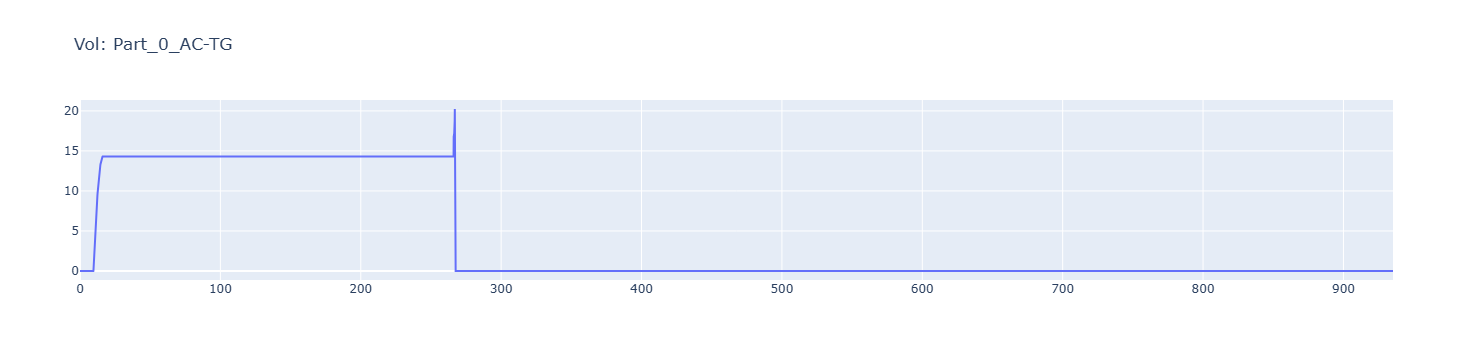

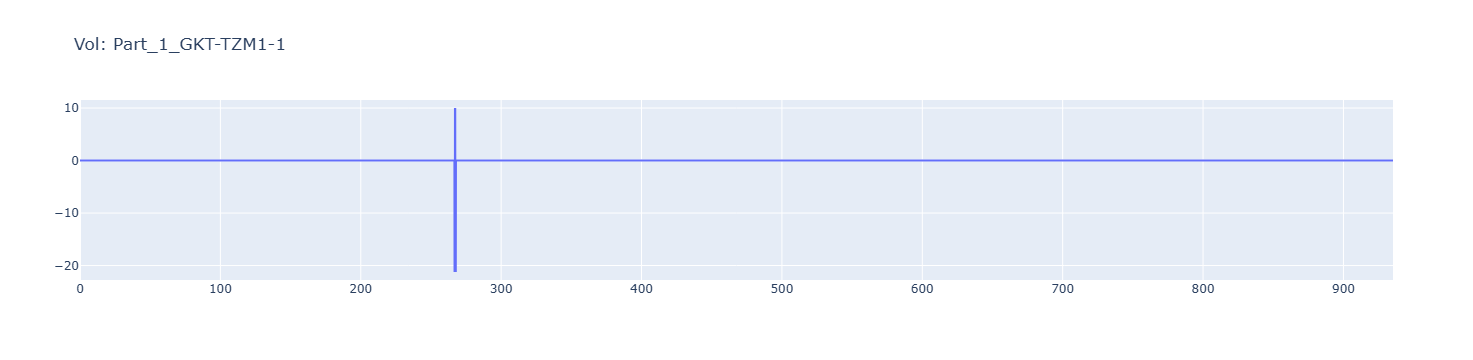

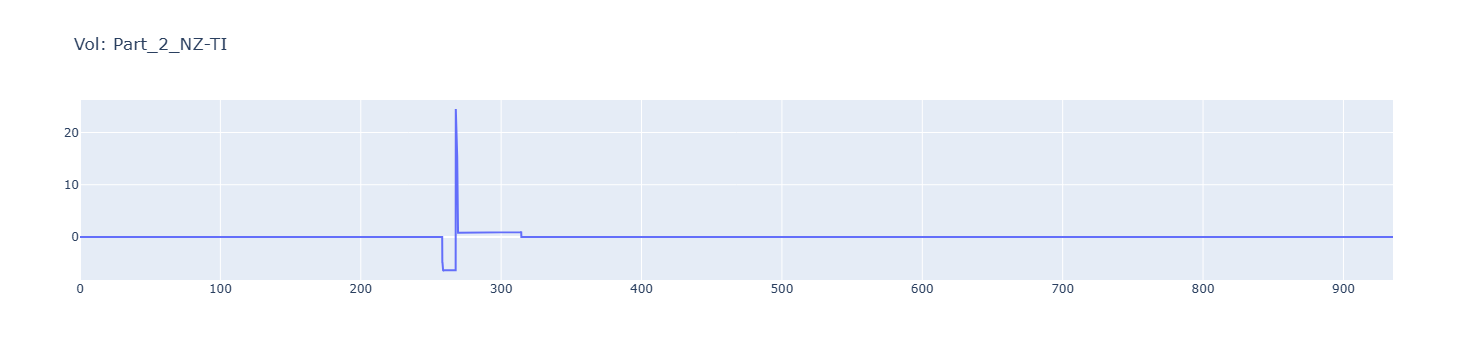

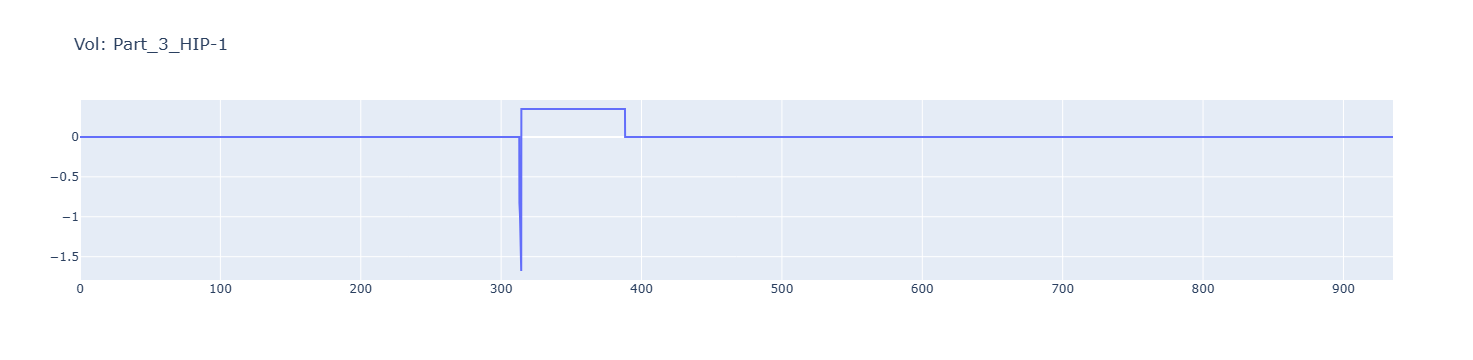

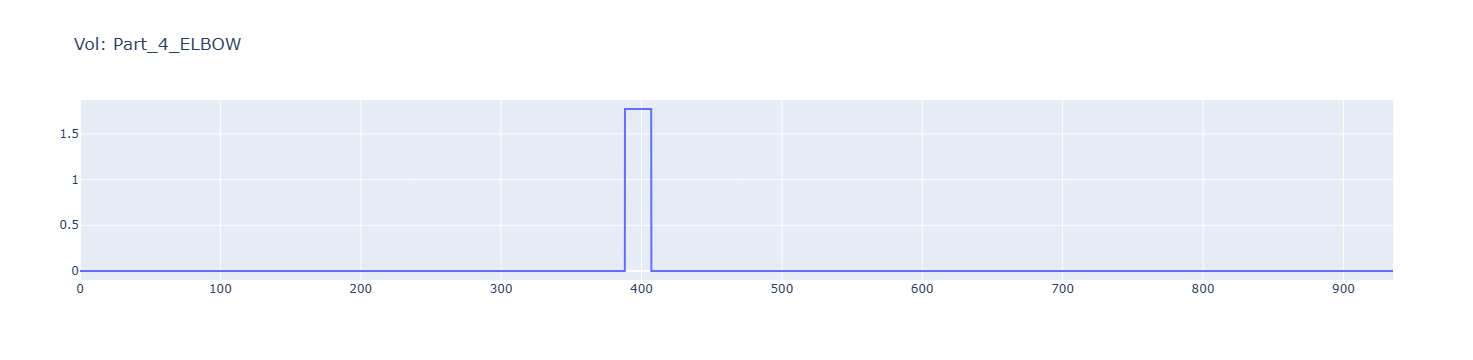

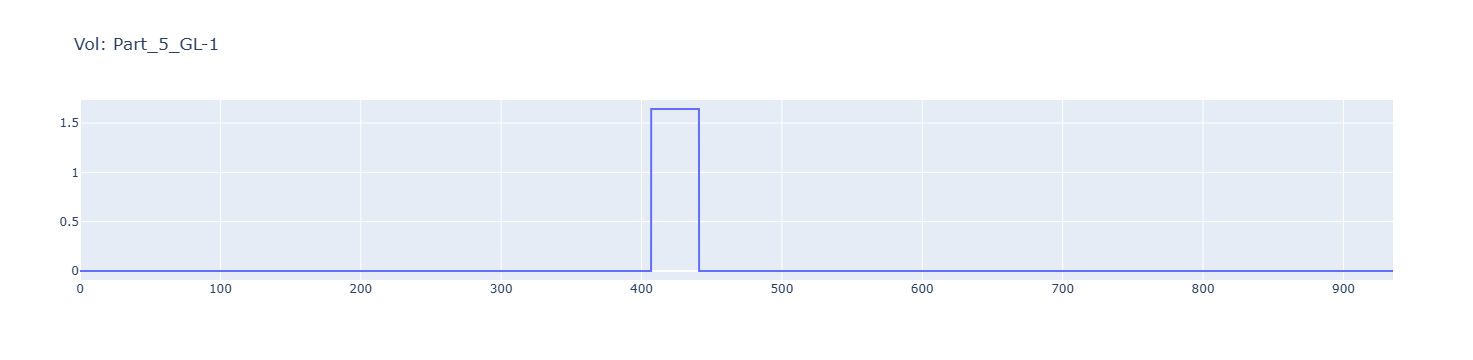

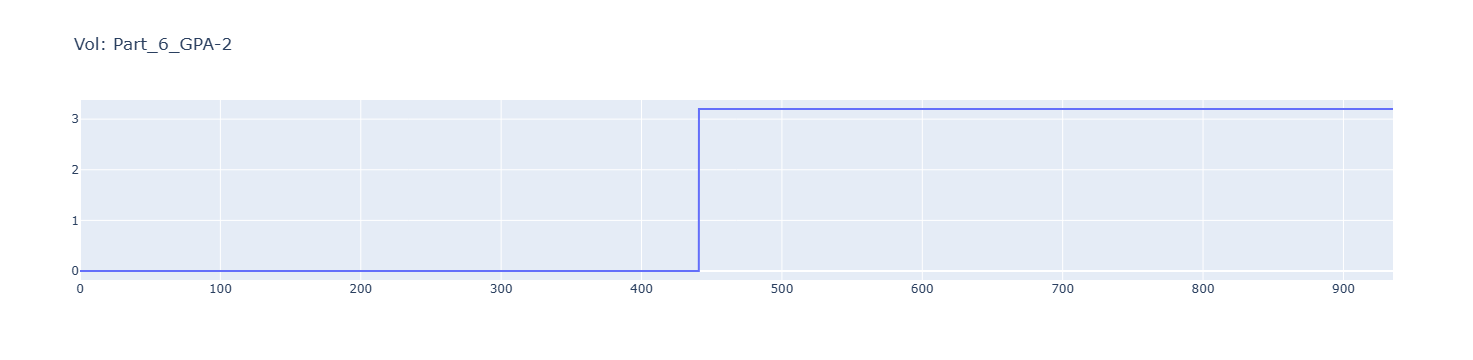

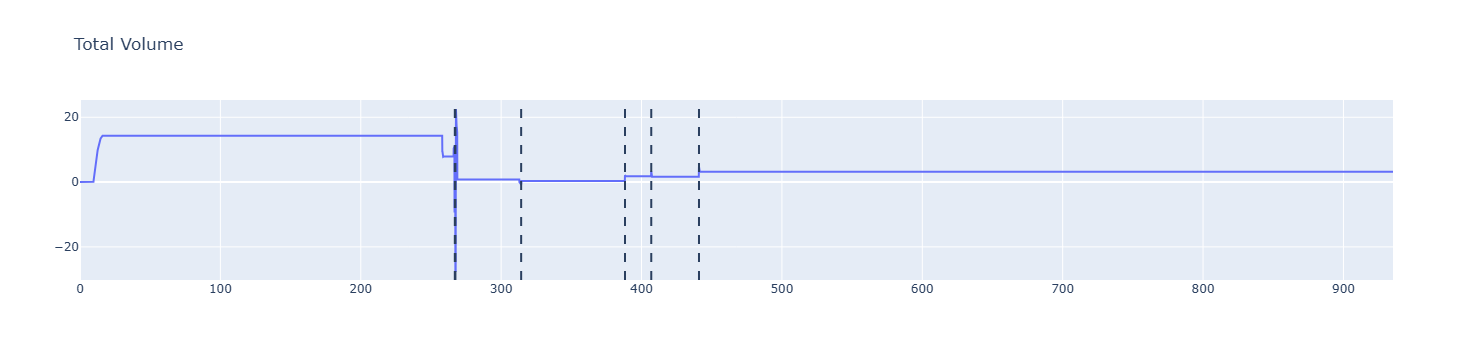


Total Vol (mL): 53.358 (DF), 53.358 (Coarse), Total Vol (m^3): 5.336e-05
Using Temperature Profile CSV...
Temp cal range from CSV: 1mm to 449mm
z_list_str (first 20, from CSV): ['1', '69', '120', '157', '195', '246', '363', '449']
Starting main calculation loop...
Step 0, Time: 0.00 hr, n: 2.105e-01 ± 7.08e-04 mol
Step 1000, Time: 0.28 hr, n: 2.106e-01 ± 7.08e-04 mol
Step 2000, Time: 0.56 hr, n: 2.107e-01 ± 7.08e-04 mol
Step 3000, Time: 0.83 hr, n: 2.104e-01 ± 7.07e-04 mol
Step 4000, Time: 1.11 hr, n: 2.106e-01 ± 7.08e-04 mol


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\jonny\anaconda3\envs\MolCalc\Lib\tkinter\__init__.py", line 2074, in __call__
    return self.func(*args)
           ~~~~~~~~~^^^^^^^
  File "C:\Users\jonny\AppData\Local\Temp\ipykernel_31580\375588915.py", line 39, in <lambda>
    graphButton=tk.Button(window, text="Generate Graph", command=lambda: processData(), anchor=W); graphButton.grid(row=22, column=1, sticky=W)
                                                                         ~~~~~~~~~~~^^
  File "C:\Users\jonny\AppData\Local\Temp\ipykernel_31580\4018336968.py", line 165, in processData
    else: tempProfile_raw = getTempProfile(temps, z_list, z_list_str, zoneBounds, zoneBoundsStr, temp_df_list)
                            ~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jonny\AppData\Local\Temp\ipykernel_31580\412153842.py", line 10, in getTempProfile
    try: idx = search_column.searchsor

In [19]:
# --- MAIN GUI ---
window=tk.Tk(); window.title("MoleGrapher 1.4.0"); window.geometry("500x580") # Updated title/size
graphLabel = tk.Label(window, text = "Press 'Generate Graph' or 'Import...' to begin.", width = 100, anchor=W); graphLabel.grid(row=1, column=1, columnspan=5, sticky=W)

# Row 11: File Browsing/Import
importPlotButton = tk.Button(window, text="Import Plot CSV", command=import_data, anchor=W); importPlotButton.grid(row=11, column=1, sticky=W)
importTempButton = tk.Button(window, text="Import Temp CSV", command=import_temp_profile_viewer, anchor=W); importTempButton.grid(row=11, column=2, sticky=W)
fileBrowseButton = tk.Button(window, text="Browse Data...", command=lambda: browseFiles(), anchor=W); fileBrowseButton.grid(row=11, column=3, sticky=W)
fileLabel = tk.Label(window, text="Data: (Not Selected)", width=40, anchor=W); fileLabel.grid(row=11, column=4, columnspan=2, sticky=W)

# Row 12: Temp Profile / Interpolation
interpolate_temps_var = tk.BooleanVar(value=False); interpolateCheckbox = tk.Checkbutton(window, text="Interpolate Temps (No CSV)", variable=interpolate_temps_var, command=toggle_temp_file_selection, anchor=W); interpolateCheckbox.grid(row=12, column=1, sticky=W)
tempLabel = tk.Label(window, text="Temp Profile: (Select via Browse)", width=100, anchor=W); tempLabel.grid(row=12, column=2, columnspan=5, sticky=W)

# Rows 13-16: Geometry Files
layoutLabel = tk.Label(window, text="Layout: (Not Selected)", width=100, anchor=W); layoutLabel.grid(row=13, column=2, columnspan=5, sticky=W)
matingLabel = tk.Label(window, text="Mating Table: (Not Selected)", width=100, anchor=W); matingLabel.grid(row=14, column=2, columnspan=5, sticky=W)
furLabel = tk.Label(window, text="MLD-FUR: (Not Selected)", width=100, anchor=W); furLabel.grid(row=15, column=2, columnspan=5, sticky=W)
hpsLabel = tk.Label(window, text="MLD-HPS: (Not Selected)", width=100, anchor=W); hpsLabel.grid(row=16, column=2, columnspan=5, sticky=W)

# Rows 17-19: Parameters
zCutoffLabel = tk.Label(window, text="Z-Temp Cutoff (mm):", width=25, anchor=W); zCutoffLabel.grid(row=17, column=1, sticky=W)
z_temp_cutoff_var = tk.StringVar(value=''); zCutoffEntry = tk.Entry(window, textvariable=z_temp_cutoff_var, width=20); zCutoffEntry.grid(row=17, column=2, sticky=W)
zOffsetLabel = tk.Label(window, text="Z-Offset (mm):", width=25, anchor=W); zOffsetLabel.grid(row=18, column=1, sticky=W)
z_offset_var = tk.StringVar(value=''); zOffsetEntry = tk.Entry(window, textvariable=z_offset_var, width=20); zOffsetEntry.grid(row=18, column=2, sticky=W)
pCalcStartTimeLabel = tk.Label(window, text="P_calc Start Time (Hours):", width=25, anchor=W); pCalcStartTimeLabel.grid(row=19, column=1, sticky=W)
p_calc_start_time_var = tk.StringVar(value=''); pCalcStartTimeEntry = tk.Entry(window, textvariable=p_calc_start_time_var, width=20); pCalcStartTimeEntry.grid(row=19, column=2, sticky=W)

# --- NEW: Row 20-21: Uncertainty Inputs ---
sigmaPLabel = tk.Label(window, text=r"$\sigma_P$ (% Error):", width=25, anchor=W); sigmaPLabel.grid(row=20, column=1, sticky=W)
sigma_p_var = tk.StringVar(value='0.25'); sigmaPEntry = tk.Entry(window, textvariable=sigma_p_var, width=10); sigmaPEntry.grid(row=20, column=2, sticky=W)
sigmaVLabel = tk.Label(window, text=r"$\sigma_V$ (% Error):", width=25, anchor=W); sigmaVLabel.grid(row=21, column=1, sticky=W)
sigma_v_var = tk.StringVar(value='5.0'); sigmaVEntry = tk.Entry(window, textvariable=sigma_v_var, width=10); sigmaVEntry.grid(row=21, column=2, sticky=W)
sigmaTLabel = tk.Label(window, text=r"$\sigma_T$ (K Error):", width=25, anchor=W); sigmaTLabel.grid(row=21, column=3, sticky=W)
sigma_t_var = tk.StringVar(value='2.2'); sigmaTEntry = tk.Entry(window, textvariable=sigma_t_var, width=10); sigmaTEntry.grid(row=21, column=4, sticky=W)
# --- END NEW ---

# Row 22: Action Buttons
graphButton=tk.Button(window, text="Generate Graph", command=lambda: processData(), anchor=W); graphButton.grid(row=22, column=1, sticky=W)
tempViewButton=tk.Button(window, text="View Temp Profiles", command=open_temp_viewer, anchor=W, state='disabled'); tempViewButton.grid(row=22, column=2, sticky=W)
exportPlotButton=tk.Button(window, text="Export Plot Data", command=export_plot_data, anchor=W, state='disabled'); exportPlotButton.grid(row=22, column=3, sticky=W)
exportTempButton = tk.Button(window, text="Export Temp Profiles", command=export_temp_profiles, anchor=W, state='disabled'); exportTempButton.grid(row=22, column=4, sticky=W, padx=5)

# Row 23-25: Fit Controls
fitStartLabel = tk.Label(window, text="Fit Start Time (Hours):", width=25, anchor=W); fitStartLabel.grid(row=23, column=1, sticky=W)
fit_start_time_var = tk.StringVar(value=''); fitStartEntry = tk.Entry(window, textvariable=fit_start_time_var, width=10); fitStartEntry.grid(row=23, column=2, sticky=W)
fitEndLabel = tk.Label(window, text="Fit End Time (Hours):", width=25, anchor=W); fitEndLabel.grid(row=24, column=1, sticky=W)
fit_end_time_var = tk.StringVar(value=''); fitEndEntry = tk.Entry(window, textvariable=fit_end_time_var, width=10); fitEndEntry.grid(row=24, column=2, sticky=W)
calculateFitButton = tk.Button(window, text="Calculate Fit", command=calculate_exponential_fit, anchor=W, state='disabled'); calculateFitButton.grid(row=23, column=3, sticky=W, rowspan=2)
fit_results_label = tk.Label(window, text="", width=100, anchor=W, height=2, justify=LEFT); fit_results_label.grid(row=25, column=1, columnspan=5, sticky=W) # Updated label

# Row 26: Progress Bars
fileProgress = Progressbar(window, orient = HORIZONTAL, length = 100, mode = 'determinate'); fileProgress.grid(row=26, column=4, sticky=E, padx=5)
graphProgress = Progressbar(window, orient = HORIZONTAL, length = 200, mode = 'determinate'); graphProgress.grid(row=26, column=2, columnspan=2, sticky=W)

window.attributes('-topmost', False)
window.mainloop()